In [1]:
import pandas as pd
import numpy
import os
from datetime import datetime
from datetime import timedelta
%matplotlib notebook
import matplotlib.pyplot as plt
import pymultinest
import json
import corner
import warnings
from glob import glob




In [77]:
class simple_multinest():
    
    def __init__(self, x, y, model, parameters):
        
        self._x = x
        self._y = y
        self._model = model
        self._parameters = parameters
        
        #parameters is a dictionar with { 'par_name': {'min': val, 'max': val}}
    
    def create_uniform_prior(self, par_name):
        
        def uniform_transform(x):
            return self._parameters[par_name]['min']+ x * (self._parameters[par_name]['max']- self._parameters[par_name]['min'])
        
        self._parameters[par_name].update(transform = uniform_transform)
        self._parameters[par_name].update(aftertransform=lambda x: x)
        
    def make_all_uniform(self):
        
        for kk in self._parameters.keys():
            self.create_uniform_prior(kk)
    
    
    def test_statistics(self, par):
        
        #print(par)
        s = self._model(self._x, par)
    
        res = s - self._y + self._y * numpy.log( self._y / s)
    
        
        
        return 2 * numpy.sum(res)
    
    def log_likelihood(self, cube, ndim, nparams):
        
        par = {}
        for i, k in enumerate(self._parameters.keys()):
            t=self._parameters[k]
            par.update({k : t['aftertransform'](cube[i])})
        
        #print(par)
        return -0.5 * self.test_statistics(par)
    
    def create_prior_function(self):
        """
        Creates a single prior transformation function from parameters
        """

        def prior(cube, ndim, nparams):
                try:
                        for i, k in enumerate(self._parameters.keys()):
                                t=self._parameters[k]
                                transform = t['transform']
                                cube[i] = transform(cube[i])
                except Exception as e:
                        print('ERROR: Exception in prior function. Faulty transformations specified!')
                        print('ERROR:', e)
                        raise e

        return prior
    
    def nested_run(self, prior_function = None, sampling_efficiency = 0.3,
        n_live_points = 400, evidence_tolerance = 0.5,
        outputfiles_basename = 'nested-', verbose=True, clean=False, **kwargs):
        
        n_params = len(self._parameters)
        
        prior_function=self.create_prior_function()
        
        if clean:
            to_be_cleaned=glob(outputfiles_basename+'*')
            for ff in to_be_cleaned:
                os.remove(ff)
        
        pymultinest.run(self.log_likelihood, prior_function, n_params,
                sampling_efficiency = sampling_efficiency, n_live_points = n_live_points,
                outputfiles_basename = outputfiles_basename,
                verbose=verbose, **kwargs)
        
        paramnames = [str(k) for k in self._parameters.keys()]
        json.dump(paramnames, open('%s-params.json' % outputfiles_basename, 'w'), indent=4)
        
        
        self._analyzer = pymultinest.Analyzer(n_params = len(self._parameters),
                                                outputfiles_basename = outputfiles_basename)
        
        return outputfiles_basename

    def marginal_plots(self,minweight=1e-4,  title='Title', **kwargs):
        """
        Create marginal plots
        
        * analyzer: A instance of pymultinest.Analyzer
        * d: if more than 20 dimensions, by default only 1d marginal distributions
           are plotted. set d=2 if you want to force a 2d matrix plot
        
        """
        prefix = self._analyzer.outputfiles_basename
        parameters = json.load(open(prefix + '-params.json'))

        data = analyzer.get_data()[:,2:]
        weights = analyzer.get_data()[:,0]

        mask = weights > minweight
        
        
        with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                corner.corner(data[mask,:], weights=weights[mask],
                        labels=parameters, show_titles=True, **kwargs)
                
        axes=plt.gcf().get_axes()
        my_ax=axes[0]
        for ax in axes[1:]:
            pos=ax.get_position()


            if pos.x0 > my_ax.get_position().x0:
                my_ax=ax
            if pos.y0 > my_ax.get_position().y0:
                my_ax=ax

        my_ax.text(0.5,0.5,title,  horizontalalignment='center',
           verticalalignment='center', transform=my_ax.transAxes, fontsize=14)
        
        plt.savefig(prefix + 'corner.pdf')
        
    def model_plot(self, nsample=100, xlabel='Days', ylabel='Poissonian variable', yscale='log', title='Title' ):
        
        posterior = self._analyzer.get_equal_weighted_posterior()
        print(len(posterior))
        if nsample > len(posterior):
            raise RuntimeError('Cannot plot more than sample')
        
        chosen = numpy.random.choice(numpy.arange(len(posterior)), replace=False, size=nsample)
        posterior = posterior[chosen,:]
        
        
        plt.figure()
        plt.errorbar(self._x, self._y, yerr=numpy.sqrt(self._y), marker='o', linestyle='')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.yscale(yscale)
        plt.title(title)
        
        xx=numpy.linspace(self._x.min(), self._x.max()+1, nsample)
        
        for k, row in enumerate(posterior):
            par = {}
            for i, k in enumerate(self._parameters.keys()):
                t=self._parameters[k]
                par.update({k : t['aftertransform'](row[i])})
            yy=self._model(xx, par)
            
            plt.plot(xx,yy, 'r-', alpha=0.5, linewidth=3)
        plt.savefig(self._analyzer.outputfiles_basename+'plt.pdf')
        

In [54]:


def pl(x,par):
    t1  = par['t1']
    b1  = par['b1']
    
    return numpy.exp(b1*(x-t1))
    


def broken_pl(x, par):
    
    #print(par)
    
    break_value = par['break']
    t1  = par['t1']
    t2  = par['t2']
    b1  = par['b1']
    b2  = par['b2']
    
    ind = x > break_value
    
    
    
    y = numpy.exp(b1*(x-t1))
    
    if numpy.sum(ind) >0:
        y[ind]=numpy.exp(b2*(x[ind]-t2))
    
    return y

def multiple_pl(x, par):
    
    #print(par)
    
    break_value1 = par['break1']
    break_value2 = par['break2']
    t1  = par['t1']
    t2  = par['t2']
    t3  = par['t3']
    b1  = par['b1']
    b2  = par['b2']
    b3  = par['b3']
    
    tb_1=break_value1
    tb_2=break_value2
    
    if tb_2 < tb_1:
        tb_1=break_value2
        tb_2=break_value1
    
    
    ind1 = x > tb_1
    ind2 = x > tb_2
        
    y = numpy.exp(b1*(x-t1))
    
    if numpy.sum(ind1) >0:
        y[ind1]=numpy.exp(b2*(x[ind1]-t2))
    if numpy.sum(ind2) >0:
        y[ind2]=numpy.exp(b3*(x[ind2]-t3))
    
    
    return y


In [84]:
#data_type='cases'
data_type='fatalities'
canton='VD'
model_name='pl'


if data_type=='cases':
    data = pd.read_csv("https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_cases_switzerland.csv")
if data_type=='fatalities':
    data = pd.read_csv("https://raw.githubusercontent.com/daenuprobst/covid19-cases-switzerland/master/covid19_fatalities_switzerland.csv")

print(data)
data = data.filter(items=['Date', canton])  # only keep data for one canton (or whole CH) in dataframe
data.rename(columns={canton: "TotalPosTests1"}, inplace=True)
data = data.dropna()  # remove dates without available data (na)
newdata = data
startrow = 0
for x in data['TotalPosTests1']:
    if x == 0:
        startrow+=1
newdata = newdata.iloc[startrow:]
inhabitantsCH = 8570000.0
datearray = newdata['Date'].to_numpy()
for x in datearray:
    x = datetime.strptime(x, '%Y-%m-%d')
datetimearray = [datetime.strptime(x, '%Y-%m-%d').date() for x in datearray]
try:
    firstdate = datetimearray[1]
except IndexError:
    sys.exit('No cases in database for {}.'.format(canton))

datesincezero = [float((x - firstdate).days) + 1.0 for x in datetimearray]
poscasearray = newdata['TotalPosTests1'].to_numpy().tolist()
x = numpy.array(datesincezero)
y = numpy.array(poscasearray)

#data.show_in_notebook()

          Date   AG  AI   AR   BE   BL   BS   FR  GE  GL  ...   SO  SZ  TG  \
0   2020-03-06  NaN NaN  NaN  0.0  NaN  NaN  NaN   0 NaN  ...  NaN NaN NaN   
1   2020-03-07  NaN NaN  NaN  0.0  NaN  NaN  NaN   0 NaN  ...  NaN NaN NaN   
2   2020-03-08  NaN NaN  NaN  0.0  NaN  NaN  NaN   0 NaN  ...  NaN NaN NaN   
3   2020-03-09  NaN NaN  NaN  0.0  NaN  NaN  NaN   1 NaN  ...  NaN NaN NaN   
4   2020-03-10  NaN NaN  NaN  0.0  NaN  NaN  NaN   2 NaN  ...  NaN NaN NaN   
5   2020-03-11  NaN NaN  NaN  0.0  NaN  NaN  NaN   2 NaN  ...  NaN NaN NaN   
6   2020-03-12  NaN NaN  NaN  0.0  NaN  NaN  NaN   2 NaN  ...  NaN NaN NaN   
7   2020-03-13  NaN NaN  NaN  0.0  NaN  NaN  NaN   2 NaN  ...  NaN NaN NaN   
8   2020-03-14  NaN NaN  NaN  0.0  NaN  NaN  NaN   2 NaN  ...  NaN NaN NaN   
9   2020-03-15  NaN NaN  NaN  0.0  NaN  2.0  NaN   4 NaN  ...  NaN NaN NaN   
10  2020-03-16  NaN NaN  NaN  1.0  NaN  4.0  NaN   4 NaN  ...  NaN NaN NaN   
11  2020-03-17  NaN NaN  NaN  NaN  NaN  4.0  NaN   4 NaN  ...  N

In [85]:



if model_name == 'broken_pl':
    parameters = {
        'break' : {'min': x.min()+1, 'max' : x.max()-1} , 
        't1' : {'min': -40, 'max' : 0.} , 
        't2' : {'min': -200, 'max' : 0.} ,  
        'b1'  : {'min': 0, 'max' : 2.} , 
        'b2' : {'min': 0, 'max' : 2.} 
    }
    model=brokel_pl
    

if model_name == 'multiple_pl':
    parameters = {
        'break1' : {'min': x.min()+1, 'max' : 11.} , 
        'break2' : {'min': 11, 'max' : x.max()-1} , 
        't1' : {'min': -40, 'max' : 0.} , 
        't2' : {'min': -200, 'max' : 0.} ,  
        't3' : {'min': -200, 'max' : 0.} ,  
        'b1'  : {'min': 0, 'max' : 2.} , 
        'b2' : {'min': 0, 'max' : 2.} ,
        'b3' : {'min': 0, 'max' : 2.} 
    }
    model=multiple_pl

if model_name == 'pl':
    parameters = {
        't1' : {'min': -40, 'max' : 0.} , 
        'b1'  : {'min': 0, 'max' : 2.} 
    }
    model=pl


today=datetime.today().strftime('%Y-%m-%d')

outputfiles_basename = today + '-' + model_name + '-'+ data_type+ '-' + canton+'-'

my_multinest=simple_multinest(x, y, model, parameters)

my_multinest.make_all_uniform()

my_multinest.nested_run(outputfiles_basename = outputfiles_basename, clean=True)

    
    
    

  analysing data from 2020-03-24-pl-fatalities-VD-.txt


'2020-03-24-pl-fatalities-VD-'

In [86]:

# analyse results
print('analysing results...')
analyzer = pymultinest.Analyzer(n_params = len(parameters),
        outputfiles_basename = outputfiles_basename)
s = analyzer.get_stats()
# store information in readable, hierarchical format
json.dump(s, open(outputfiles_basename + 'stats.json', 'w'), indent=4)

#   print out summary
print()
print()
print('Parameter estimation summary')
print('****************************')
print()
print(' %20s: median, 10%%, q90%% quantile' % ('parameter name'))
print(' ', '-'*20)
for t, m in zip(parameters.keys(), s['marginals']):
        print(' %20s: %.3f  %.3f %.3f ' % (t, m['median'], m['q10%'], m['q90%']))
print()
print()
print('Model evidence: ln(Z) = %.2f +- %.2f' % (s['global evidence'], s['global evidence error']))
print()


analysing results...
  analysing data from 2020-03-24-pl-fatalities-VD-.txt


Parameter estimation summary
****************************

       parameter name: median, 10%, q90% quantile
  --------------------
                   t1: -5.477  -9.210 -3.042 
                   b1: 0.180  0.141 0.219 


Model evidence: ln(Z) = -8.19 +- 0.03



1363


<IPython.core.display.Javascript object>


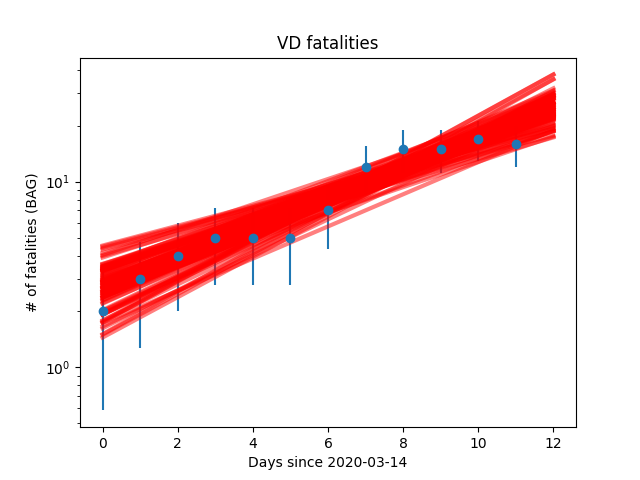

In [87]:
xlabel= "Days since %s"%firstdate.strftime('%Y-%m-%d')
ylabel= '# of '+data_type+' (BAG)'
yscale='log'
my_multinest.model_plot(100, xlabel, ylabel, yscale, title=canton+ ' ' + data_type)



<IPython.core.display.Javascript object>


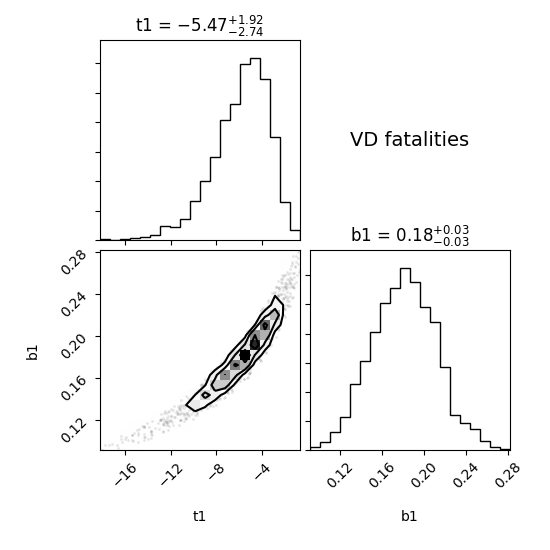

In [88]:
my_multinest.marginal_plots(title=canton+ ' ' + data_type)

In [57]:
from math import log, log10

prefixes=['2020-03-24-bkn2-VD-',  '2020-03-24-bkn-VD-',  '2020-03-24-VD-']

models = dict([(f, json.load(open(f + "stats.json"))['global evidence']) for f in prefixes])

best = max(models, key=models.__getitem__)
Zbest = models[best]
for m in models: models[m] -= Zbest
Ztotal = log(sum(numpy.exp([Z for Z in list(models.values())])))
limit = 30 # for example, Jeffreys scale for the Bayes factor

print()
print('Model comparison')
print('****************')
print()
for m in sorted(models, key=models.__getitem__):
        Zrel = models[m]
        print('model %-10s: log10(Z) = %7.1f %s' % (m, Zrel / log(10),
                ' XXX ruled out' if Zrel < Ztotal - log(limit) else '   <-- GOOD' ))

print()
print('The last, most likely model was used as normalization.')
print('Uniform model priors are assumed, with a cut of log10(%s) to rule out models.' % limit)
print()



Model comparison
****************

model 2020-03-24-VD-: log10(Z) =   -69.6  XXX ruled out
model 2020-03-24-bkn2-VD-: log10(Z) =    -1.2    <-- GOOD
model 2020-03-24-bkn-VD-: log10(Z) =     0.0    <-- GOOD

The last, most likely model was used as normalization.
Uniform model priors are assumed, with a cut of log10(30) to rule out models.

